In [1]:
import numpy as np
from scipy.stats import spearmanr
from scipy import sparse
import cmath
from sklearn.decomposition import PCA
import sys, os
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.pyplot import cm
import matplotlib.patches as patches




sys.path.append('/mnt/e/dhh-soltesz-lab/zfish-proj/src-parallel/operation-figgeritout/comp-modeling/utils')
from futils import read_metrics_filepath, extract_weights, data2percentile, get_hilbert, get_phases, get_synch, jthreshold

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

%load_ext autoreload
%autoreload 2

In [93]:
fish_id = 2
traces_filepath = '../data/fish-%i-processed.npz' % fish_id
bin_filepath    = '/mnt/f/dhh-soltesz-lab/zfish-fc/f%i/bin' % fish_id
gt_filepath     = '/mnt/f/dhh-soltesz-lab/zfish-fc/f%i/gt' % fish_id
# snap_filepath   = '/mnt/f/dhh-soltesz-lab/zfish-fc/f%i/snap' % fish_id
metrics_filepath = '/mnt/f/dhh-soltesz-lab/zfish-fc/f%i/graph-metrics' % fish_id

nmatrices = 2380
window = 120
presz_start_idx = 500
sz_start_idx = 1370
#fish 2 - 1370
#fish 3 - 1270
#fish 5 - 2190
#fish 6 - 1360

f = np.load(traces_filepath)
traces = f['traces']
coords = f['coords']
f.close()
N, T = traces.shape
complete_times = np.arange(0, traces.shape[1]) * 0.5
dynamic_times  = complete_times[window:]
print(N,T)

6701 2500


In [94]:
## Extract graph metrics

#metrics_filepath = '/mnt/f/dhh-soltesz-lab/ca1-data/JF_200_105/graph-metrics'
# coords_filepath  = '/mnt/f/dhh-soltesz-lab/zfish-modeling-outputs/f2/baseline/v1/additional-info-3152020.npz'
# f = np.load(coords_filepath)
# coords = f['spatial']

nmatrices=2380
dynamic_degree_centrality, dynamic_eigenvector_centrality, dynamic_clustering_coefficient = read_metrics_filepath(metrics_filepath, nmatrices, [], verbose=True)
dynamic_degree_centrality_percentile, dynamic_eigenvector_centrality_percentile, dynamic_cc_percentile  = [], [], []
method = 'average'

for i in range(len(dynamic_degree_centrality)):
    dynamic_degree_centrality_percentile.append(data2percentile(dynamic_degree_centrality[i], method=method))
    dynamic_eigenvector_centrality_percentile.append(data2percentile(dynamic_eigenvector_centrality[i], method=method))
    dynamic_cc_percentile.append(data2percentile(dynamic_clustering_coefficient[i], method=method))
dynamic_degree_centrality_percentile      = np.asarray(dynamic_degree_centrality_percentile, dtype='float32')
dynamic_eigenvector_centrality_percentile = np.asarray(dynamic_eigenvector_centrality_percentile, dtype='float32')
dynamic_cc_percentile = np.asarray(dynamic_cc_percentile, dtype='float32')

dynamic_ev_deg_correlation = []
for i in range(len(dynamic_degree_centrality_percentile)):
    deg = dynamic_degree_centrality_percentile[i]
    ev  = dynamic_eigenvector_centrality_percentile[i]
    
    rho, _ = spearmanr(deg, ev)
    dynamic_ev_deg_correlation.append(rho)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300


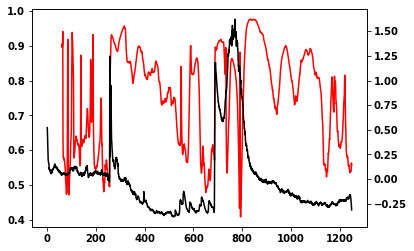

In [95]:
fig, ax = plt.subplots()
ax.plot(dynamic_times, dynamic_ev_deg_correlation, color='r')
ax2 = ax.twinx()
ax2.plot(complete_times, np.mean(traces,axis=0), color='k')
plt.show()


In [51]:
def extract_leiden_modularity(xcorr, res, binary=None, part=None):
    from graph_utils import leiden_clustering
    labels, modularity = leiden_clustering(xcorr , res=res, directed=False, part=part)   
    return labels, modularity
  

# sort and get modularities of 
def get_spatiotemporal_mod(sorted_raster, csz_lst, res=1.0, metric='cosine'):      
    from scipy.spatial.distance import pdist
    from scipy.spatial.distance import squareform
    membership = None
    if csz_lst is not None:
        membership = []
        mid = 0
        for sz in csz_lst:
            membership.extend([mid for _ in range(sz)])
            mid += 1  
    space = None
    if metric == 'cosine':
        from sklearn.metrics.pairwise import cosine_similarity
        space = cosine_similarity(sorted_raster)  
    elif metric == 'corr':
        space = np.corrcoef(sorted_raster)
        space = np.clip(space, 0., 1.) 
    elif metric == 'jaccard':
        space = squareform(1. - pdist(sorted_raster, metric='jaccard'))
    elif metric == 'euclidean':
        space = squareform(pdist(sorted_raster, metric='euclidean'))
        space = (1./(1.+space))
    slabels, smod = extract_leiden_modularity(space, res=res, part=membership)
    return slabels, smod

def extract_ensembles(raster):
    from futils import ensemble_detection
  
    ensemble_kwargs = {'metric': 'cosine', 'k': 20, 'stopping_condition': 1e-3, 'resolution': 1.2}
    sam, umap_data, cluster_labels = ensemble_detection(raster, run_sam=True, **ensemble_kwargs)
    return sam, umap_data, cluster_labels


def rasterize(idxs, component, temporal_cutoff=0.50, spatial_cutoff=0.90, valid_idxs=None):
    raster = []
    times = list(range(0,360))+list(range(620,sz_start_idx-120))
    for i in idxs:
        d, e = dynamic_degree_centrality_percentile[i], dynamic_eigenvector_centrality_percentile[i]
        locs = None
        if component == 'shubs':
            locs = np.where( (d > spatial_cutoff) & (e > spatial_cutoff))[0]
        elif component == 'nhubs':
            locs = np.where(d > spatial_cutoff)[0]
        elif component == 'hubs':
            locs = np.where( (d > spatial_cutoff) & (e <= spatial_cutoff) )[0]
        raster_slice = np.zeros(len(d), dtype='uint8')
        raster_slice[locs] = 1
        raster.append(raster_slice)
    raster = np.asarray(raster, dtype='uint8')      
    
    if valid_idxs is None:
        raster_mean = np.mean(raster, axis=0)
        mean_cutoff = np.percentile(raster_mean, 100.*temporal_cutoff)
        valid_idxs = np.where(raster_mean > mean_cutoff)[0]
    raster = raster[:, valid_idxs]
    return np.asarray(raster, dtype='uint8'), valid_idxs

def sort_dstructure(raster, labels, dtype='uint8', tpose=False):
    labels = np.asarray(labels, dtype='uint32')
    label_set = list(set(labels))
    sorted_raster = np.zeros_like(raster, dtype=dtype)
    
    csz_lst = []
    for label in label_set:
        idxs = np.where(labels == label)[0]
        csize = len(idxs)
        csz_lst.append(csize)
        
    sorted_idxs = np.argsort(csz_lst)[::-1]
    count = 0
    for idx in sorted_idxs:
        idxs = np.where(labels == label_set[idx])[0]
        csz = len(idxs)
        sorted_raster[:,count:count+csz] = raster[:, idxs]
        count += csz
    if tpose:
        sorted_raster = sorted_raster.T
    return sorted_raster, np.sort(csz_lst)[::-1]


def spatial_clustering_algorithm(start, stop, temporal_cutoff, dtype='uint8', verbose=False):
    raster, valid_idxs = rasterize(range(start,stop), 'shubs', temporal_cutoff=temporal_cutoff)
    _, _, spatial_labels = extract_ensembles(raster.T) # get assemblies   
    
    sorted_raster, csz_spatial_lst = sort_dstructure(raster, spatial_labels, dtype=dtype, tpose=False)
    sorted_spatial_labels, spatial_modularity   = get_spatiotemporal_mod(sorted_raster.T, csz_spatial_lst,
                                                                         res=1.0, metric='jaccard')
    sorted_temporal_labels, temporal_modularity = get_spatiotemporal_mod(sorted_raster, None, 
                                                                         res=1.0, metric='corr')
    
    
    if verbose:
        print('temporal mod: %0.3f' % temporal_modularity)
        print('spatial mod: %0.3f' % spatial_modularity)
    
    return {'raster': raster, 'csz_spatial_lst': csz_spatial_lst, 'sorted raster': sorted_raster,
           'valid idxs': valid_idxs, 'slabels': sorted_spatial_labels, 'smod': spatial_modularity,
           'tlabels': sorted_temporal_labels, 'tmod': temporal_modularity,
           'oslabels': spatial_labels}


In [230]:
#use for rolled dataset
rolled = spatial_clustering_algorithm(25,240+25, temporal_cutoff=0.50, dtype='uint8', verbose=True)

Transforming to str index.
Transforming to str index.


temporal mod: 0.077
spatial mod: 0.132


0.027060747611632775
0.02710208239456162
0.026759396752518334
0.02788423535098887
0.028206078663738605
0.027988648118179176
0.027694730966582468
0.02779536749404347
0.028342075094765877
0.028315887572428866
0.027472571994172926
0.027531497047627133
0.02678126480031502
0.026441591534671204
0.02712335314954672
0.026422114296634058
0.026212543748867133
0.025689213634662287
0.024443257780976894
0.02430454073005405
0.02333393976892361
0.02263908865846288
0.02193430078300977
0.02112613925783072
[0.027060747611632775, 0.02710208239456162, 0.026759396752518334, 0.02788423535098887, 0.028206078663738605, 0.027988648118179176, 0.027694730966582468, 0.02779536749404347, 0.028342075094765877, 0.028315887572428866, 0.027472571994172926, 0.027531497047627133, 0.02678126480031502, 0.026441591534671204, 0.02712335314954672, 0.026422114296634058, 0.026212543748867133, 0.025689213634662287, 0.024443257780976894, 0.02430454073005405, 0.02333393976892361, 0.02263908865846288, 0.02193430078300977, 0.021126

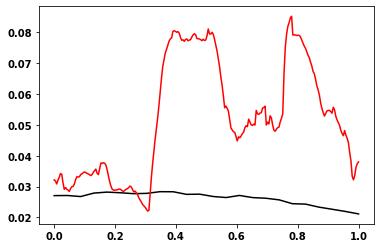

In [36]:

def algo2(start, stop, sorted_raster, csz_lst, dtype='uint8', verbose=False):
    sliced_raster = sorted_raster[start:stop, :]
    sorted_spatial_labels, spatial_modularity = get_spatiotemporal_mod(sliced_raster.T, csz_lst, res=1.0, metric='jaccard')
    #sorted_temporal_labels, temporal_modularity = get_spatiotemporal_mod(sliced_raster, None, res=1.0, metric='corr')
    return spatial_modularity



baseline_raster, baseline_valid_idxs = rasterize(range(0,360), 'shubs', temporal_cutoff=0.80)
_, _, baseline_assembly_labels = extract_ensembles(dynamic_eigenvector_centrality.T)
baseline_sorted_raster, baseline_csz_lst = sort_dstructure(dynamic_eigenvector_centrality, baseline_assembly_labels, dtype='float32', tpose=False)

baseline_mods = []
for i in range(0, 360-240, 5):
    baseline_mods.append(algo2(i, i+240, full_sorted, full_csz_lst))

print(baseline_mods)
# presz_raster, presz_valid_idxs = rasterize(range(620,sz_start_idx-120), 'shubs', temporal_cutoff=0.80, valid_idxs=baseline_valid_idxs)
#_, _, presz_assembly_labels = extract_ensembles(presz_raster.T)
#presz_sorted_raster, presz_csz_lst = sort_dstructure(presz_raster, baseline_assembly_labels, dtype='uint8', tpose=False)


presz_mods = []
for ii,i in enumerate(range(620, sz_start_idx-120-240, 5)):
    presz_mods.append(algo2(i, i+240, full_sorted, full_csz_lst))

plt.figure()
plt.plot(np.linspace(0., 1., len(baseline_mods)), baseline_mods, color='k')
plt.plot(np.linspace(0., 1., len(presz_mods)), presz_mods, color='r')
plt.show()


Transforming to str index.
Transforming to str index.


0.038432815379980036


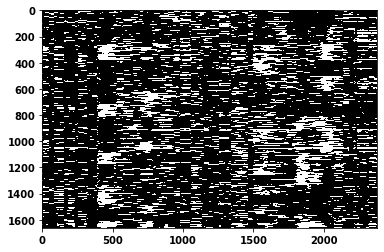

In [96]:
raster, valid_idxs = rasterize(range(0,2380), 'shubs', 0.75)
_, _, full_assembly_labels = extract_ensembles(raster.T)
full_sorted, full_csz_lst  = sort_dstructure(raster, full_assembly_labels, dtype='float32')
_, smod = get_spatiotemporal_mod(full_sorted.T, full_csz_lst, res=1.0, metric='jaccard')
print(smod)

plt.figure()
plt.imshow(full_sorted.T, cmap='gray', aspect='auto')
plt.show()



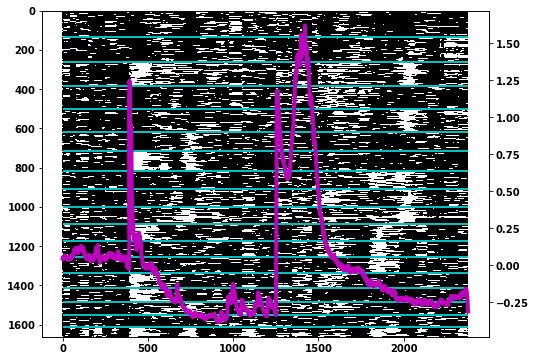

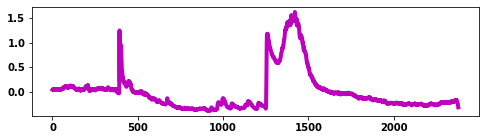

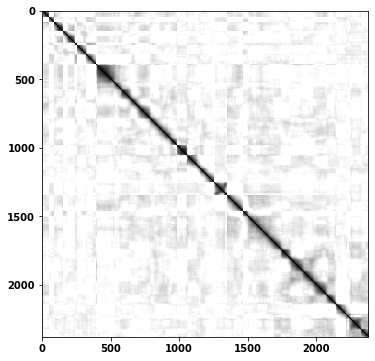

In [97]:
fig, ax = plt.subplots(figsize=(8,6))
ax.imshow(full_sorted.T, cmap='gray', aspect='auto', 
          vmin=np.percentile(full_sorted,5), vmax=np.percentile(full_sorted,95))
count = 0
for csz in full_csz_lst:
    ax.hlines(count, 0, full_sorted.shape[0], color='c', linewidth=2)
    count += csz
    
ax2 = ax.twinx()
#ax2.plot(dynamic_ev_deg_correlation[:], color='m', linewidth=1)
ax2.plot(np.mean(traces,axis=0)[120:], color='m', linewidth=4)
plt.show()

plt.figure(figsize=(8,2))
#plt.plot(dynamic_ev_deg_correlation[:], color='m', linewidth=4)
plt.plot(np.mean(traces,axis=0)[120:], color='m', linewidth=4)
plt.show()


plt.figure(figsize=(8,6))
plt.imshow(np.corrcoef(full_sorted), vmin=0., vmax=1., cmap='gray_r')
plt.show()



Transforming to str index.
Transforming to str index.


temporal mod: 0.607
spatial mod: 0.190


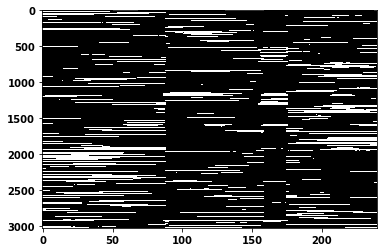

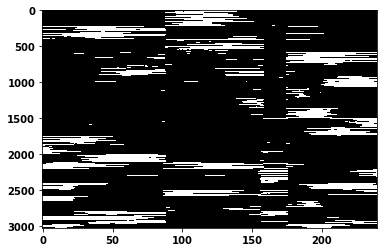

In [50]:
# baseline_superhub_outputs = {}
# for i in range(0, 360-240, 5):
#    baseline_superhub_outputs[i] = spatial_clustering_algorithm(i, i+240, temporal_cutoff=0.95, dtype='uint8', verbose=True)
#    print(i)

baseline_superhub_outputs[0] = spatial_clustering_algorithm(120, 360, temporal_cutoff=0.50, dtype='uint8', verbose=True)
plt.figure()
plt.imshow(baseline_superhub_outputs[0]['raster'].T, cmap='gray', aspect='auto')
plt.show()

plt.figure()
plt.imshow(baseline_superhub_outputs[0]['sorted raster'].T, cmap='gray', aspect='auto')
plt.show()


0.5346964152470898 0.0782586228638795 3


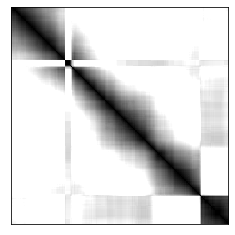

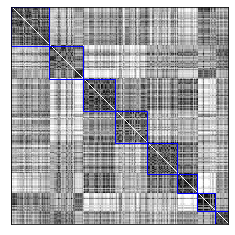

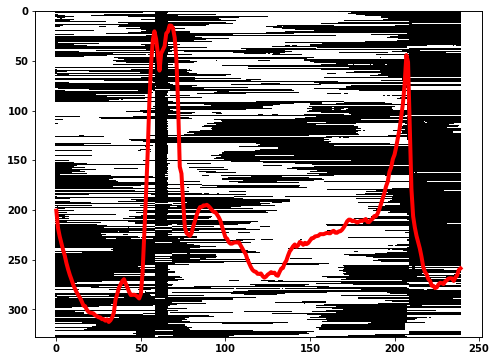

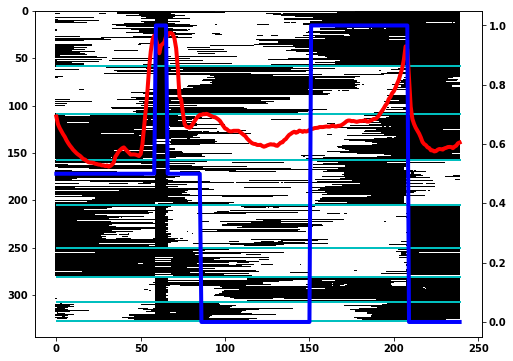

In [38]:
def plot_data(X, k, duration):
    from sklearn.metrics.pairwise import cosine_similarity
    from scipy.spatial.distance import pdist
    from scipy.spatial.distance import squareform
    
    raster        = X['raster']
    sorted_raster = X['sorted raster']
    csz_spatial_lst = X['csz_spatial_lst']
    #csz_temporal_lst = X['csz_temporal_lst']
    
    print(X['tmod'], X['smod'], len(set(X['tlabels'])))
       
    #time = squareform(1.-pdist(sorted_raster, metric='cosine'))
    time = np.corrcoef(sorted_raster)
    time = np.clip(time, 0., 1.)
    tlabels = X['tlabels']
    tlabel_idxs = np.argsort(tlabels)
    fig, ax = plt.subplots()
    ax.imshow(time, cmap='gray_r', vmin=0., vmax=1.)
#     count = 0
#     for sz in csz_temporal_lst:
#         p = patches.Rectangle((count, count), sz, sz, linewidth=2, edgecolor='r', facecolor='none')
#         ax.add_patch(p)
#         count += sz 
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()
    
    space = squareform(1.-pdist(sorted_raster.T, metric='jaccard'))
    slabels = X['slabels']
    slabel_idxs = np.argsort(slabels)
    space = space[slabel_idxs,:]; space = space[:, slabel_idxs]
    
    fig, ax = plt.subplots()
    plt.imshow(space, vmin=0., vmax=1., cmap='gray_r')
    count = 0
    for sz in csz_spatial_lst:
        p = patches.Rectangle((count, count), sz, sz, linewidth=1, edgecolor='b', facecolor='none')
        ax.add_patch(p)
        count += sz 
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()     
    
    
    fig, ax = plt.subplots(figsize=(8,6))
    ax.imshow(raster.T, cmap='gray', aspect='auto')
    ax2 = ax.twinx()
    #ax2.plot(np.divide(tlabels,float(np.max(tlabels))), color='r', linewidth=4)
    ax2.plot(dynamic_ev_deg_correlation[k:k+duration], color='r', linewidth=4)
    ax2.set_yticks([])
    plt.show()
    
    fig, ax = plt.subplots(figsize=(8,6))
    ax.imshow(sorted_raster.T, cmap='gray', aspect='auto')
    count = 0
    for sz in csz_spatial_lst:
        count += sz
        ax.hlines(count, 0, raster.shape[0], color='C', linewidth=2)

    ax2 = ax.twinx()
    ax2.plot(dynamic_ev_deg_correlation[k:k+duration], color='r', linewidth=4)
    ax2.plot(np.asarray(tlabels)/float(np.max(tlabels)), color='b', linewidth=4)
    plt.show()
    
    
pkeys = np.sort(list(baseline_superhub_outputs.keys()))
smods =[]
for k in pkeys:
    smods.append(baseline_superhub_outputs[k]['smod'])
max_key = pkeys[np.argsort(smods)[::-1][0]]
min_key = pkeys[np.argsort(smods)[0]]

key = 0
plot_data(baseline_superhub_outputs[key], key, 240)


In [39]:
presz_superhub_outputs = {}

# T x N 
for i in range(620, sz_start_idx-120-240, 5):
    presz_superhub_outputs[i] = spatial_clustering_algorithm(i, i+240, temporal_cutoff=0.90, verbose=True)
    print(i)


#presz_superhub_outputs[620] = spatial_clustering_algorithm(sz_start_idx-120-240, sz_start_idx-120, temporal_cutoff=0.80, verbose=True)
#presz_superhub_outputs[620] = spatial_clustering_algorithm(620, 620+240, temporal_cutoff=0.80, verbose=True)


Transforming to str index.
Transforming to str index.
Transforming to str index.
Transforming to str index.


temporal mod: 0.601
spatial mod: 0.112
620


Transforming to str index.
Transforming to str index.


temporal mod: 0.600
spatial mod: 0.139
625


Transforming to str index.
Transforming to str index.


temporal mod: 0.599
spatial mod: 0.114
630


Transforming to str index.
Transforming to str index.


temporal mod: 0.598
spatial mod: 0.115
635


Transforming to str index.
Transforming to str index.


temporal mod: 0.597
spatial mod: 0.114
640


Transforming to str index.
Transforming to str index.


temporal mod: 0.594
spatial mod: 0.128
645


Transforming to str index.
Transforming to str index.


temporal mod: 0.593
spatial mod: 0.113
650


Transforming to str index.
Transforming to str index.


temporal mod: 0.589
spatial mod: 0.118
655


Transforming to str index.
Transforming to str index.


temporal mod: 0.585
spatial mod: 0.111
660


Transforming to str index.
Transforming to str index.


temporal mod: 0.580
spatial mod: 0.112
665


Transforming to str index.
Transforming to str index.


temporal mod: 0.580
spatial mod: 0.103
670


Transforming to str index.
Transforming to str index.


temporal mod: 0.581
spatial mod: 0.116
675


Transforming to str index.
Transforming to str index.


temporal mod: 0.582
spatial mod: 0.124
680


Transforming to str index.
Transforming to str index.


temporal mod: 0.577
spatial mod: 0.116
685


Transforming to str index.
Transforming to str index.


temporal mod: 0.579
spatial mod: 0.107
690


Transforming to str index.
Transforming to str index.


temporal mod: 0.579
spatial mod: 0.106
695


Transforming to str index.
Transforming to str index.


temporal mod: 0.584
spatial mod: 0.121
700


Transforming to str index.
Transforming to str index.


temporal mod: 0.569
spatial mod: 0.133
705


Transforming to str index.
Transforming to str index.


temporal mod: 0.556
spatial mod: 0.111
710


Transforming to str index.
Transforming to str index.


temporal mod: 0.548
spatial mod: 0.131
715


Transforming to str index.
Transforming to str index.


temporal mod: 0.526
spatial mod: 0.127
720


Transforming to str index.
Transforming to str index.


temporal mod: 0.524
spatial mod: 0.112
725


Transforming to str index.
Transforming to str index.


temporal mod: 0.525
spatial mod: 0.116
730


Transforming to str index.
Transforming to str index.


temporal mod: 0.570
spatial mod: 0.114
735


Transforming to str index.
Transforming to str index.


temporal mod: 0.584
spatial mod: 0.106
740


Transforming to str index.
Transforming to str index.


temporal mod: 0.597
spatial mod: 0.130
745


Transforming to str index.
Transforming to str index.


temporal mod: 0.610
spatial mod: 0.131
750


Transforming to str index.
Transforming to str index.


temporal mod: 0.622
spatial mod: 0.135
755


Transforming to str index.
Transforming to str index.


temporal mod: 0.625
spatial mod: 0.135
760


Transforming to str index.
Transforming to str index.


temporal mod: 0.624
spatial mod: 0.136
765


Transforming to str index.
Transforming to str index.


temporal mod: 0.619
spatial mod: 0.132
770


Transforming to str index.
Transforming to str index.


temporal mod: 0.614
spatial mod: 0.117
775


Transforming to str index.
Transforming to str index.


temporal mod: 0.601
spatial mod: 0.115
780


Transforming to str index.
Transforming to str index.


temporal mod: 0.535
spatial mod: 0.120
785


Transforming to str index.
Transforming to str index.


temporal mod: 0.458
spatial mod: 0.123
790


Transforming to str index.
Transforming to str index.


temporal mod: 0.519
spatial mod: 0.106
795


Transforming to str index.
Transforming to str index.


temporal mod: 0.458
spatial mod: 0.106
800


Transforming to str index.
Transforming to str index.


temporal mod: 0.458
spatial mod: 0.101
805


Transforming to str index.
Transforming to str index.


temporal mod: 0.514
spatial mod: 0.107
810


Transforming to str index.
Transforming to str index.


temporal mod: 0.496
spatial mod: 0.111
815


Transforming to str index.
Transforming to str index.


temporal mod: 0.528
spatial mod: 0.117
820


Transforming to str index.
Transforming to str index.


temporal mod: 0.544
spatial mod: 0.108
825


Transforming to str index.
Transforming to str index.


temporal mod: 0.554
spatial mod: 0.127
830


Transforming to str index.
Transforming to str index.


temporal mod: 0.557
spatial mod: 0.118
835


Transforming to str index.
Transforming to str index.


temporal mod: 0.576
spatial mod: 0.113
840


Transforming to str index.
Transforming to str index.


temporal mod: 0.590
spatial mod: 0.131
845


Transforming to str index.
Transforming to str index.


temporal mod: 0.593
spatial mod: 0.137
850


Transforming to str index.
Transforming to str index.


temporal mod: 0.595
spatial mod: 0.159
855


Transforming to str index.
Transforming to str index.


temporal mod: 0.591
spatial mod: 0.149
860


Transforming to str index.
Transforming to str index.


temporal mod: 0.584
spatial mod: 0.150
865


Transforming to str index.
Transforming to str index.


temporal mod: 0.530
spatial mod: 0.154
870


Transforming to str index.
Transforming to str index.


temporal mod: 0.509
spatial mod: 0.145
875


Transforming to str index.
Transforming to str index.


temporal mod: 0.493
spatial mod: 0.143
880


Transforming to str index.
Transforming to str index.


temporal mod: 0.487
spatial mod: 0.146
885


Transforming to str index.
Transforming to str index.


temporal mod: 0.479
spatial mod: 0.132
890


Transforming to str index.
Transforming to str index.


temporal mod: 0.503
spatial mod: 0.143
895


Transforming to str index.
Transforming to str index.


temporal mod: 0.490
spatial mod: 0.156
900


Transforming to str index.
Transforming to str index.


temporal mod: 0.534
spatial mod: 0.142
905


Transforming to str index.
Transforming to str index.


temporal mod: 0.541
spatial mod: 0.141
910


Transforming to str index.
Transforming to str index.


temporal mod: 0.537
spatial mod: 0.171
915


Transforming to str index.
Transforming to str index.


temporal mod: 0.566
spatial mod: 0.131
920


Transforming to str index.
Transforming to str index.


temporal mod: 0.569
spatial mod: 0.153
925


Transforming to str index.
Transforming to str index.


temporal mod: 0.572
spatial mod: 0.142
930


Transforming to str index.
Transforming to str index.


temporal mod: 0.581
spatial mod: 0.138
935


Transforming to str index.
Transforming to str index.


temporal mod: 0.586
spatial mod: 0.142
940


Transforming to str index.
Transforming to str index.


temporal mod: 0.593
spatial mod: 0.129
945


Transforming to str index.
Transforming to str index.


temporal mod: 0.595
spatial mod: 0.131
950


Transforming to str index.
Transforming to str index.


temporal mod: 0.597
spatial mod: 0.118
955


Transforming to str index.
Transforming to str index.


temporal mod: 0.596
spatial mod: 0.118
960


Transforming to str index.
Transforming to str index.


temporal mod: 0.592
spatial mod: 0.121
965


Transforming to str index.
Transforming to str index.


temporal mod: 0.582
spatial mod: 0.116
970


Transforming to str index.
Transforming to str index.


temporal mod: 0.569
spatial mod: 0.104
975


Transforming to str index.
Transforming to str index.


temporal mod: 0.558
spatial mod: 0.104
980


Transforming to str index.
Transforming to str index.


temporal mod: 0.542
spatial mod: 0.110
985


Transforming to str index.
Transforming to str index.


temporal mod: 0.515
spatial mod: 0.106
990


Transforming to str index.
Transforming to str index.


temporal mod: 0.496
spatial mod: 0.106
995


Transforming to str index.
Transforming to str index.


temporal mod: 0.468
spatial mod: 0.102
1000


Transforming to str index.
Transforming to str index.


temporal mod: 0.435
spatial mod: 0.099
1005


Transforming to str index.
Transforming to str index.


temporal mod: 0.435
spatial mod: 0.099
1010


Transforming to str index.
Transforming to str index.


temporal mod: 0.472
spatial mod: 0.116
1015


Transforming to str index.
Transforming to str index.


temporal mod: 0.441
spatial mod: 0.110
1020


Transforming to str index.
Transforming to str index.


temporal mod: 0.445
spatial mod: 0.106
1025


Transforming to str index.
Transforming to str index.


temporal mod: 0.448
spatial mod: 0.108
1030


Transforming to str index.
Transforming to str index.


temporal mod: 0.450
spatial mod: 0.119
1035


Transforming to str index.
Transforming to str index.


temporal mod: 0.504
spatial mod: 0.118
1040


Transforming to str index.
Transforming to str index.


temporal mod: 0.447
spatial mod: 0.122
1045


Transforming to str index.
Transforming to str index.


temporal mod: 0.496
spatial mod: 0.114
1050


Transforming to str index.
Transforming to str index.


temporal mod: 0.479
spatial mod: 0.119
1055


Transforming to str index.
Transforming to str index.


temporal mod: 0.483
spatial mod: 0.109
1060


Transforming to str index.
Transforming to str index.


temporal mod: 0.500
spatial mod: 0.122
1065


Transforming to str index.
Transforming to str index.


temporal mod: 0.453
spatial mod: 0.114
1070


Transforming to str index.
Transforming to str index.


temporal mod: 0.458
spatial mod: 0.126
1075


Transforming to str index.
Transforming to str index.


temporal mod: 0.464
spatial mod: 0.120
1080


Transforming to str index.
Transforming to str index.


temporal mod: 0.470
spatial mod: 0.112
1085


Transforming to str index.
Transforming to str index.


temporal mod: 0.479
spatial mod: 0.106
1090


Transforming to str index.
Transforming to str index.


temporal mod: 0.487
spatial mod: 0.117
1095


Transforming to str index.
Transforming to str index.


temporal mod: 0.487
spatial mod: 0.112
1100


Transforming to str index.
Transforming to str index.


temporal mod: 0.490
spatial mod: 0.098
1105


Transforming to str index.
Transforming to str index.


temporal mod: 0.495
spatial mod: 0.105
1110


Transforming to str index.
Transforming to str index.


temporal mod: 0.495
spatial mod: 0.112
1115


Transforming to str index.
Transforming to str index.


temporal mod: 0.492
spatial mod: 0.110
1120


Transforming to str index.
Transforming to str index.


temporal mod: 0.488
spatial mod: 0.092
1125


Transforming to str index.
Transforming to str index.


temporal mod: 0.477
spatial mod: 0.098
1130


Transforming to str index.
Transforming to str index.


temporal mod: 0.466
spatial mod: 0.099
1135


Transforming to str index.
Transforming to str index.


temporal mod: 0.456
spatial mod: 0.097
1140


Transforming to str index.
Transforming to str index.


temporal mod: 0.451
spatial mod: 0.092
1145


Transforming to str index.
Transforming to str index.


temporal mod: 0.450
spatial mod: 0.098
1150


Transforming to str index.
Transforming to str index.


temporal mod: 0.439
spatial mod: 0.096
1155


Transforming to str index.
Transforming to str index.


temporal mod: 0.439
spatial mod: 0.104
1160


Transforming to str index.
Transforming to str index.


temporal mod: 0.460
spatial mod: 0.106
1165


Transforming to str index.
Transforming to str index.


temporal mod: 0.486
spatial mod: 0.091
1170


Transforming to str index.
Transforming to str index.


temporal mod: 0.521
spatial mod: 0.080
1175


Transforming to str index.
Transforming to str index.


temporal mod: 0.526
spatial mod: 0.080
1180


Transforming to str index.
Transforming to str index.


temporal mod: 0.523
spatial mod: 0.074
1185


Transforming to str index.
Transforming to str index.


temporal mod: 0.518
spatial mod: 0.074
1190


Transforming to str index.
Transforming to str index.


temporal mod: 0.516
spatial mod: 0.080
1195


Transforming to str index.
Transforming to str index.


temporal mod: 0.512
spatial mod: 0.073
1200


Transforming to str index.
Transforming to str index.


temporal mod: 0.472
spatial mod: 0.082
1205


Transforming to str index.
Transforming to str index.


temporal mod: 0.468
spatial mod: 0.084
1210


Transforming to str index.
Transforming to str index.


temporal mod: 0.493
spatial mod: 0.079
1215


Transforming to str index.
Transforming to str index.


temporal mod: 0.513
spatial mod: 0.073
1220


Transforming to str index.
Transforming to str index.


temporal mod: 0.531
spatial mod: 0.073
1225


Transforming to str index.
Transforming to str index.


temporal mod: 0.542
spatial mod: 0.080
1230


Transforming to str index.
Transforming to str index.


temporal mod: 0.538
spatial mod: 0.088
1235


Transforming to str index.
Transforming to str index.


temporal mod: 0.543
spatial mod: 0.087
1240


Transforming to str index.
Transforming to str index.


temporal mod: 0.546
spatial mod: 0.092
1245


Transforming to str index.
Transforming to str index.


temporal mod: 0.544
spatial mod: 0.097
1250


Transforming to str index.
Transforming to str index.


temporal mod: 0.515
spatial mod: 0.107
1255


Transforming to str index.
Transforming to str index.


temporal mod: 0.559
spatial mod: 0.107
1260


Transforming to str index.
Transforming to str index.


temporal mod: 0.585
spatial mod: 0.097
1265


Transforming to str index.
Transforming to str index.


temporal mod: 0.550
spatial mod: 0.112
1270


Transforming to str index.
Transforming to str index.


temporal mod: 0.548
spatial mod: 0.109
1275


Transforming to str index.
Transforming to str index.


temporal mod: 0.539
spatial mod: 0.123
1280


Transforming to str index.
Transforming to str index.


temporal mod: 0.552
spatial mod: 0.136
1285


Transforming to str index.
Transforming to str index.


temporal mod: 0.545
spatial mod: 0.143
1290


Transforming to str index.
Transforming to str index.


temporal mod: 0.543
spatial mod: 0.150
1295


Transforming to str index.
Transforming to str index.


temporal mod: 0.532
spatial mod: 0.136
1300


Transforming to str index.
Transforming to str index.


temporal mod: 0.514
spatial mod: 0.155
1305


Transforming to str index.
Transforming to str index.


temporal mod: 0.502
spatial mod: 0.139
1310


Transforming to str index.
Transforming to str index.


temporal mod: 0.507
spatial mod: 0.146
1315


Transforming to str index.
Transforming to str index.


temporal mod: 0.522
spatial mod: 0.135
1320


Transforming to str index.
Transforming to str index.


temporal mod: 0.505
spatial mod: 0.129
1325


Transforming to str index.
Transforming to str index.


temporal mod: 0.527
spatial mod: 0.131
1330


Transforming to str index.
Transforming to str index.


temporal mod: 0.516
spatial mod: 0.125
1335


Transforming to str index.
Transforming to str index.


temporal mod: 0.518
spatial mod: 0.118
1340


Transforming to str index.
Transforming to str index.


temporal mod: 0.519
spatial mod: 0.109
1345


Transforming to str index.
Transforming to str index.


temporal mod: 0.569
spatial mod: 0.099
1350


Transforming to str index.
Transforming to str index.


temporal mod: 0.588
spatial mod: 0.079
1355


Transforming to str index.
Transforming to str index.


temporal mod: 0.580
spatial mod: 0.074
1360


Transforming to str index.
Transforming to str index.


temporal mod: 0.577
spatial mod: 0.059
1365


Transforming to str index.
Transforming to str index.


temporal mod: 0.570
spatial mod: 0.053
1370


Transforming to str index.
Transforming to str index.


temporal mod: 0.564
spatial mod: 0.058
1375


Transforming to str index.
Transforming to str index.


temporal mod: 0.544
spatial mod: 0.058
1380


Transforming to str index.
Transforming to str index.


temporal mod: 0.532
spatial mod: 0.051
1385


Transforming to str index.
Transforming to str index.


temporal mod: 0.465
spatial mod: 0.042
1390


Transforming to str index.
Transforming to str index.


temporal mod: 0.463
spatial mod: 0.042
1395


Transforming to str index.
Transforming to str index.


temporal mod: 0.463
spatial mod: 0.046
1400


Transforming to str index.
Transforming to str index.


temporal mod: 0.466
spatial mod: 0.048
1405


Transforming to str index.
Transforming to str index.


temporal mod: 0.457
spatial mod: 0.044
1410


Transforming to str index.
Transforming to str index.


temporal mod: 0.450
spatial mod: 0.042
1415


Transforming to str index.
Transforming to str index.


temporal mod: 0.452
spatial mod: 0.040
1420


Transforming to str index.
Transforming to str index.


temporal mod: 0.442
spatial mod: 0.039
1425


Transforming to str index.
Transforming to str index.


temporal mod: 0.433
spatial mod: 0.041
1430


Transforming to str index.
Transforming to str index.


temporal mod: 0.423
spatial mod: 0.039
1435


Transforming to str index.
Transforming to str index.


temporal mod: 0.409
spatial mod: 0.043
1440


Transforming to str index.
Transforming to str index.


temporal mod: 0.392
spatial mod: 0.039
1445


Transforming to str index.
Transforming to str index.


temporal mod: 0.379
spatial mod: 0.041
1450


Transforming to str index.
Transforming to str index.


temporal mod: 0.369
spatial mod: 0.040
1455


Transforming to str index.
Transforming to str index.


temporal mod: 0.357
spatial mod: 0.039
1460


Transforming to str index.
Transforming to str index.


temporal mod: 0.351
spatial mod: 0.039
1465


Transforming to str index.
Transforming to str index.


temporal mod: 0.346
spatial mod: 0.039
1470


Transforming to str index.
Transforming to str index.


temporal mod: 0.344
spatial mod: 0.038
1475


Transforming to str index.
Transforming to str index.


temporal mod: 0.334
spatial mod: 0.036
1480


Transforming to str index.
Transforming to str index.


temporal mod: 0.351
spatial mod: 0.036
1485


Transforming to str index.
Transforming to str index.


temporal mod: 0.298
spatial mod: 0.030
1490


Transforming to str index.
Transforming to str index.


temporal mod: 0.286
spatial mod: 0.034
1495


Transforming to str index.
Transforming to str index.


temporal mod: 0.286
spatial mod: 0.031
1500


Transforming to str index.
Transforming to str index.


temporal mod: 0.322
spatial mod: 0.032
1505


Transforming to str index.
Transforming to str index.


temporal mod: 0.308
spatial mod: 0.035
1510


Transforming to str index.
Transforming to str index.


temporal mod: 0.400
spatial mod: 0.040
1515


Transforming to str index.
Transforming to str index.


temporal mod: 0.327
spatial mod: 0.042
1520


Transforming to str index.
Transforming to str index.


temporal mod: 0.358
spatial mod: 0.052
1525


Transforming to str index.
Transforming to str index.


temporal mod: 0.362
spatial mod: 0.053
1530


Transforming to str index.
Transforming to str index.


temporal mod: 0.359
spatial mod: 0.050
1535


Transforming to str index.
Transforming to str index.


temporal mod: 0.363
spatial mod: 0.049
1540


Transforming to str index.
Transforming to str index.


temporal mod: 0.366
spatial mod: 0.047
1545


Transforming to str index.
Transforming to str index.


temporal mod: 0.372
spatial mod: 0.047
1550


Transforming to str index.
Transforming to str index.


temporal mod: 0.377
spatial mod: 0.049
1555


Transforming to str index.
Transforming to str index.


temporal mod: 0.384
spatial mod: 0.052
1560


Transforming to str index.
Transforming to str index.


temporal mod: 0.497
spatial mod: 0.056
1565


Transforming to str index.
Transforming to str index.


temporal mod: 0.407
spatial mod: 0.068
1570


Transforming to str index.
Transforming to str index.


temporal mod: 0.500
spatial mod: 0.069
1575


Transforming to str index.
Transforming to str index.


temporal mod: 0.506
spatial mod: 0.067
1580


Transforming to str index.
Transforming to str index.


temporal mod: 0.506
spatial mod: 0.064
1585


Transforming to str index.
Transforming to str index.


temporal mod: 0.570
spatial mod: 0.070
1590


Transforming to str index.
Transforming to str index.


temporal mod: 0.591
spatial mod: 0.067
1595


Transforming to str index.
Transforming to str index.


temporal mod: 0.610
spatial mod: 0.075
1600


Transforming to str index.
Transforming to str index.


temporal mod: 0.617
spatial mod: 0.075
1605


Transforming to str index.
Transforming to str index.


temporal mod: 0.617
spatial mod: 0.083
1610


Transforming to str index.
Transforming to str index.


temporal mod: 0.624
spatial mod: 0.086
1615


Transforming to str index.
Transforming to str index.


temporal mod: 0.615
spatial mod: 0.078
1620


Transforming to str index.
Transforming to str index.


temporal mod: 0.581
spatial mod: 0.077
1625


Transforming to str index.
Transforming to str index.


temporal mod: 0.606
spatial mod: 0.073
1630


Transforming to str index.
Transforming to str index.


temporal mod: 0.446
spatial mod: 0.071
1635


Transforming to str index.
Transforming to str index.


temporal mod: 0.458
spatial mod: 0.068
1640


Transforming to str index.
Transforming to str index.


temporal mod: 0.458
spatial mod: 0.067
1645


Transforming to str index.
Transforming to str index.


temporal mod: 0.449
spatial mod: 0.063
1650


Transforming to str index.
Transforming to str index.


temporal mod: 0.440
spatial mod: 0.056
1655


Transforming to str index.
Transforming to str index.


temporal mod: 0.431
spatial mod: 0.054
1660


Transforming to str index.
Transforming to str index.


temporal mod: 0.413
spatial mod: 0.046
1665


Transforming to str index.
Transforming to str index.


temporal mod: 0.395
spatial mod: 0.044
1670


Transforming to str index.
Transforming to str index.


temporal mod: 0.387
spatial mod: 0.044
1675


Transforming to str index.
Transforming to str index.


temporal mod: 0.385
spatial mod: 0.044
1680


Transforming to str index.
Transforming to str index.


temporal mod: 0.500
spatial mod: 0.038
1685


Transforming to str index.
Transforming to str index.


temporal mod: 0.496
spatial mod: 0.036
1690


Transforming to str index.
Transforming to str index.


temporal mod: 0.490
spatial mod: 0.039
1695


Transforming to str index.
Transforming to str index.


temporal mod: 0.465
spatial mod: 0.029
1700


Transforming to str index.
Transforming to str index.


temporal mod: 0.443
spatial mod: 0.031
1705


Transforming to str index.
Transforming to str index.


temporal mod: 0.439
spatial mod: 0.032
1710


Transforming to str index.
Transforming to str index.


temporal mod: 0.386
spatial mod: 0.030
1715


Transforming to str index.
Transforming to str index.


temporal mod: 0.382
spatial mod: 0.032
1720


Transforming to str index.
Transforming to str index.


temporal mod: 0.406
spatial mod: 0.029
1725


Transforming to str index.
Transforming to str index.


temporal mod: 0.392
spatial mod: 0.030
1730


Transforming to str index.
Transforming to str index.


temporal mod: 0.402
spatial mod: 0.027
1735


Transforming to str index.
Transforming to str index.


temporal mod: 0.419
spatial mod: 0.029
1740


Transforming to str index.
Transforming to str index.


temporal mod: 0.408
spatial mod: 0.028
1745


Transforming to str index.
Transforming to str index.


temporal mod: 0.398
spatial mod: 0.027
1750


Transforming to str index.
Transforming to str index.


temporal mod: 0.405
spatial mod: 0.027
1755


Transforming to str index.
Transforming to str index.


temporal mod: 0.434
spatial mod: 0.034
1760


Transforming to str index.
Transforming to str index.


temporal mod: 0.460
spatial mod: 0.034
1765


Transforming to str index.
Transforming to str index.


temporal mod: 0.407
spatial mod: 0.035
1770


Transforming to str index.
Transforming to str index.


temporal mod: 0.405
spatial mod: 0.035
1775


Transforming to str index.
Transforming to str index.


temporal mod: 0.397
spatial mod: 0.032
1780


Transforming to str index.
Transforming to str index.


temporal mod: 0.391
spatial mod: 0.030
1785


Transforming to str index.
Transforming to str index.


temporal mod: 0.385
spatial mod: 0.033
1790


Transforming to str index.
Transforming to str index.


temporal mod: 0.396
spatial mod: 0.034
1795


Transforming to str index.
Transforming to str index.


temporal mod: 0.396
spatial mod: 0.036
1800


Transforming to str index.
Transforming to str index.


temporal mod: 0.400
spatial mod: 0.035
1805


Transforming to str index.
Transforming to str index.


temporal mod: 0.391
spatial mod: 0.038
1810


Transforming to str index.
Transforming to str index.


temporal mod: 0.413
spatial mod: 0.042
1815


Transforming to str index.
Transforming to str index.


temporal mod: 0.447
spatial mod: 0.047
1820
temporal mod: 0.470
spatial mod: 0.050
1825


In [52]:
import pickle

#pickle.dump( presz_superhub_outputs, open( "spatial-f6-pre-80.pkl", "wb" ) )
#pickle.dump( baseline_superhub_outputs, open( "spatial-f6-base-80.pkl", "wb" ) )

baseline_superhub_outputs = pickle.load( open( "spatial-f6-base-80.pkl", "rb" ) )
presz_superhub_outputs = pickle.load( open( "spatial-f6-pre-80.pkl", "rb" ) )



0.39820830711506283 0.026501346414583432 3


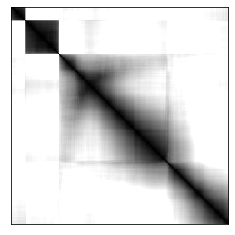

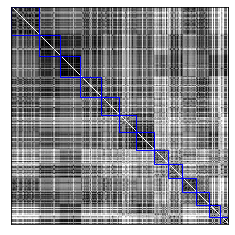

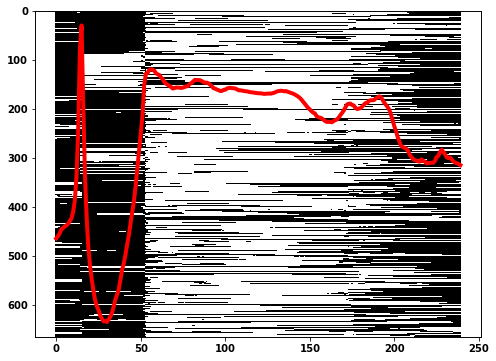

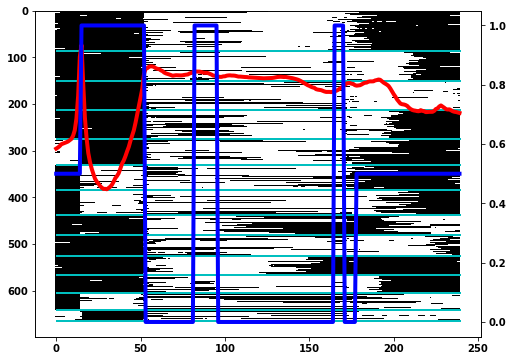

In [44]:

pkeys = np.sort(list(presz_superhub_outputs.keys()))
smods =[]
for k in pkeys:
    smods.append(presz_superhub_outputs[k]['smod'])
max_key = pkeys[np.argsort(smods)[::-1][0]]
min_key = pkeys[np.argsort(smods)[0]]

key = min_key #1100,1600
plot_data(presz_superhub_outputs[key], key, 240)


0.31329337937888996 0.4632175008211353 0.3978102786802477


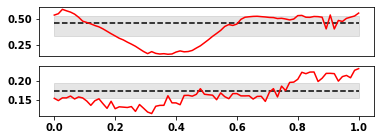

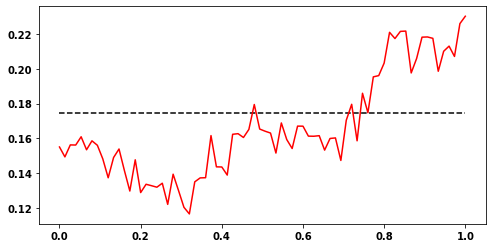

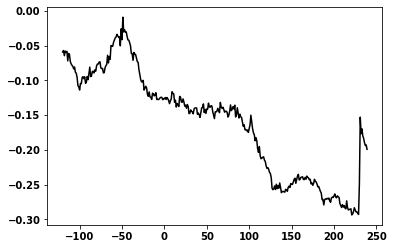

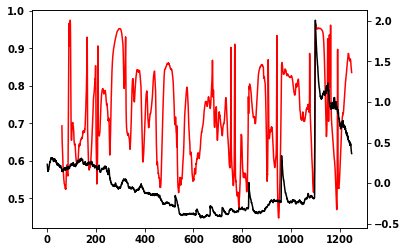

In [53]:

btmods = []
for key in np.sort(list(baseline_superhub_outputs.keys())):
    btmods.append(baseline_superhub_outputs[key]['tmod'])
btmean, btstd = np.mean(btmods), np.std(btmods)

ptmods = []
for key in np.sort(list(presz_superhub_outputs.keys())):
    ptmods.append(presz_superhub_outputs[key]['tmod'])


### space

bsmods = []
for key in np.sort(list(baseline_superhub_outputs.keys())):
    bsmods.append(baseline_superhub_outputs[key]['smod'])
bsmean, bsstd = np.mean(bsmods), np.std(bsmods)

psmods = []
for key in np.sort(list(presz_superhub_outputs.keys())):
    psmods.append(presz_superhub_outputs[key]['smod'])

#pkeys = np.sort(list(presz_superhub_outputs.keys()))
bkeys = np.linspace(0,1,len(bsmods))
pkeys = np.linspace(0,1,len(psmods))

fig, ax = plt.subplots(2,1,figsize=(6,2))
ax[0].plot(pkeys, [btmean for _ in ptmods], color='k', linestyle='--')
ax[0].fill_between(pkeys, btmean - 2.*btstd, btmean+1.*btstd, color='k', alpha=0.1)
ax[0].plot(pkeys,ptmods, color='r')
ax[0].set_xticks([])
ax[1].plot(pkeys, [bsmean for _ in psmods], color='k', linestyle='--')
ax[1].fill_between(pkeys, bsmean - 1.*bsstd, bsmean+1.*bsstd, color='k', alpha=0.1)
ax[1].plot(pkeys,psmods, color='r')

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(pkeys,[bsmean for _ in psmods], color='k', linestyle='--')
ax.plot(pkeys,psmods, color='r')

# 1100
start = 700
print(presz_superhub_outputs[start]['tmod'], btmean, btmean-btstd)

fig, ax = plt.subplots()
ax.plot(np.arange(-120, 240), np.mean(traces,axis=0)[start:start+240+120], color='k')
#ax2 = ax.twinx()
#ax2.plot(dynamic_ev_deg_correlation[start:start+300], color='r')

plt.show()


fig, ax = plt.subplots()
ax.plot(dynamic_times, dynamic_ev_deg_correlation, color='r')
ax2 = ax.twinx()
ax2.plot(complete_times, np.mean(traces,axis=0), color='k')
plt.show()


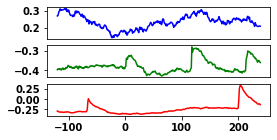

In [395]:
def plot_traces(starts, duration, colors):
    mt = np.mean(traces,axis=0)
    fig, ax = plt.subplots(len(colors),1, figsize=(4,2))
    for i in range(len(colors)):
        cstart = starts[i]
        ccolor = colors[i]
        
        ax[i].plot(np.arange(-120,duration), mt[cstart:cstart+duration+120], color=ccolor)
        if i < len(colors) - 1:
            ax[i].set_xticks([])
        

plot_traces([25, 1100, 1600], 240, ['b', 'g', 'r'])

In [306]:
def plot_superhub_subnetworks(spatial_coords, traces, key, valid_idxs, sorted_idxs, raster, cluster_ids, view, colors=None, plot=True):
    #sorted_spatial_coords, _ = sort_dstructure(coords[superhub_valid_idxs,:].T, superhub_slabels, dtype='uint8', tpose=True)

    cluster_ids = np.asarray(cluster_ids, dtype='uint32')
    cluster_id_set = np.sort(list(set(cluster_ids)))
    valid_spatial_coords = spatial_coords[valid_idxs,:]
    valid_spatial_coords, _ = sort_dstructure(valid_spatial_coords.T, sorted_idxs, dtype='float32', tpose=True)
    valid_traces = traces[valid_idxs, :]
    valid_traces, _ = sort_dstructure(valid_traces.T, sorted_idxs, dtype='float32', tpose=True)

    if colors is None:
        colors = cm.Dark2(np.linspace(0,1,len(cluster_id_set)))

    sactive_szs = []
    for cid in cluster_id_set:
        ts = np.where(cluster_ids == cid)[0]
        reduced_raster = raster[ts, :]
        tactive, sactive = np.where(reduced_raster == 1)
        sactive = list(set(sactive))
        sactive_szs.append(len(sactive))
    
    nneurons = []
    for cid in np.argsort(sactive_szs)[::-1]:
        ts = np.where(cluster_ids == cid)[0]
        reduced_raster = raster[ts, :]
        tactive, sactive = np.where(reduced_raster == 1)
        sactive = list(set(sactive))
        nneurons.append(len(sactive))
        if plot:
            duration=240
            fig = plt.figure(figsize=(12,8))
            ax = plt.axes(projection='3d')
            ax.scatter(*coords.T, color='k', alpha=0.05)
            ax.scatter(*valid_spatial_coords[sactive,:].T, color=colors, alpha=1.0)
            ax.view_init(view[0], view[1])
            plt.show()
            mean_trace = np.mean(valid_traces,axis=0)
            state_traces = valid_traces[sactive,key:key+duration+120]
            fig, ax = plt.subplots(figsize=(8,2))
            ax.plot(np.arange(-120, duration), state_traces[0:25,:].T, color=colors, alpha=0.15)
            ax2 = ax.twinx()
            ax2.plot(np.arange(-120,duration), np.mean(state_traces,axis=0), color=colors, linewidth=4)
            ax2.plot(np.arange(-120, duration), mean_trace[key:key+duration+120], color='k', linewidth=2, alpha=0.5)
    return nneurons
    


def plot_ensembles(spatial_coords, traces, key, valid_idxs, sorted_idxs, raster, cluster_ids, view, colors=None, plot=True):
    cluster_ids = np.asarray(cluster_ids, dtype='uint32')
    cluster_id_set = np.sort(list(set(cluster_ids)))
    valid_spatial_coords = spatial_coords[valid_idxs,:]
    valid_spatial_coords, _ = sort_dstructure(valid_spatial_coords.T, sorted_idxs, dtype='float32', tpose=True)   
    valid_traces = traces[valid_idxs]
    valid_traces, _ = sort_dstructure(valid_traces.T, sorted_idxs, dtype='float32', tpose=True)
    if colors is None:
        colors = cm.Dark2(np.linspace(0,1,len(cluster_id_set)))
    

    nneurons = []
    distances = []
    for cid in cluster_id_set:
        sactive = np.where(cluster_ids == cid)[0]
        ensemble_coords = valid_spatial_coords[sactive]
        xmean, ymean, zmean = np.mean(ensemble_coords[:,0]), np.mean(ensemble_coords[:,1]), np.mean(ensemble_coords[:,2])
        
        cds = []
        for ec_x,ec_y,ec_z in ensemble_coords:
            d = np.sqrt( (xmean - ec_x) ** 2 + (ymean - ec_y) ** 2 + (zmean - ec_z) ** 2)
            cds.append(d)
        distances.append(np.std(cds))
        
        duration=240
        nneurons.append(len(sactive))
        if plot:
            fig = plt.figure(figsize=(12,8))
            ax = plt.axes(projection='3d')
            ax.scatter(*coords.T, color='k', alpha=0.05)
            ax.scatter(*valid_spatial_coords[sactive,:].T, color=colors, alpha=1.0)
            ax.view_init(view[0], view[1])
            plt.show()

            mean_trace = np.mean(valid_traces,axis=0)
            state_traces = valid_traces[sactive,key:key+duration+120]
            normalized_state_traces = []
            for trace in state_traces:
                ct = trace - np.min(trace)
                ct /= np.max(ct)
                normalized_state_traces.append(ct)
            normalized_state_traces = np.asarray(normalized_state_traces, dtype='float32')
            
            print(len(sactive))
            fig, ax = plt.subplots(figsize=(8,2))
            ax.plot(np.arange(-120, duration), normalized_state_traces[0:25,:].T, color=colors, alpha=0.15)
            ax2 = ax.twinx()
            ax2.plot(np.arange(-120, duration), mean_trace[key:key+duration+120], color='k', linewidth=2)
    return nneurons, distances


In [385]:

def raster_assembly_sparsity(raster, labels, cutoff=0.50):
    labels = np.asarray(labels)
    T, N = raster.shape
    sparsity_lst = []
    for t in range(T):
        count = 0
        active_assemblies = 0
        for label in set(labels):
            idxs = np.where(labels == label)[0]
            current_assembly = raster[t,idxs]
            if np.sum(current_assembly)/float(len(idxs)) > cutoff: active_assemblies += 1
        sparsity_lst.append(active_assemblies / float(len(set(labels))))
    return np.asarray(sparsity_lst, dtype='float32')


def extract_subnetwork_data(X, key, cutoff=0.50):
    neurons_per_subnetwork = plot_superhub_subnetworks(coords, traces, key, X[key]['valid idxs'], X[key]['oslabels'],
                                                      X[key]['sorted raster'], X[key]['tlabels'], [90,0],
                                                      colors='b', plot=False)
    neurons_per_assembly, assembly_distances = plot_ensembles(coords, traces, key, X[key]['valid idxs'], X[key]['oslabels'],
                                                      X[key]['sorted raster'], X[key]['tlabels'], [90,0],
                                                      colors='b', plot=False)
    
    sparsity = raster_assembly_sparsity(X[key]['sorted raster'], X[key]['slabels'], cutoff=cutoff)
    
    
    
    return neurons_per_subnetwork, neurons_per_assembly, assembly_distances, sparsity


subnetwork_data = {}
keys = [25, 1100, 1600]
cutoff =0.75
for key in keys:
    if key <= 360:
        subnetwork_data[key] = extract_subnetwork_data(baseline_superhub_outputs, key, cutoff=cutoff)
    else:
        subnetwork_data[key] = extract_subnetwork_data(presz_superhub_outputs, key, cutoff=cutoff)
    print(key)

25
1100
1600


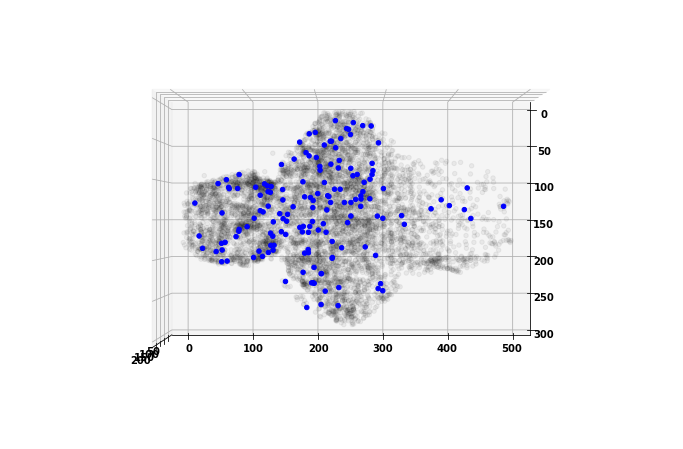

153


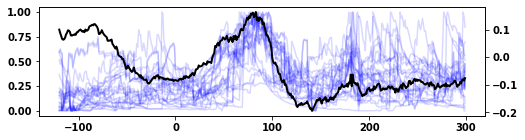

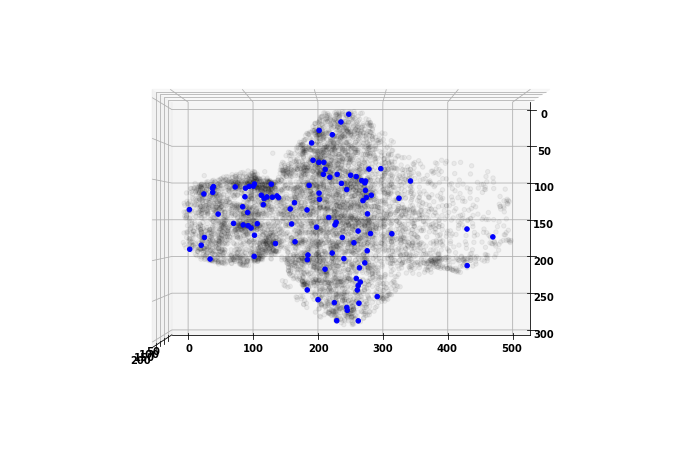

103


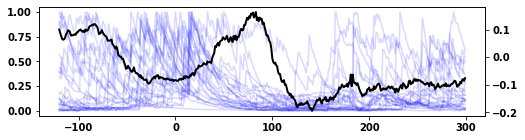

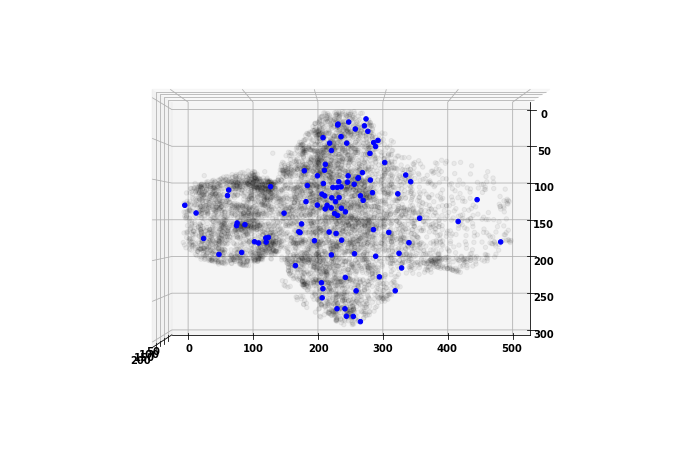

103


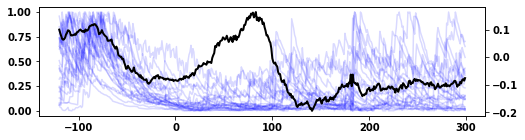

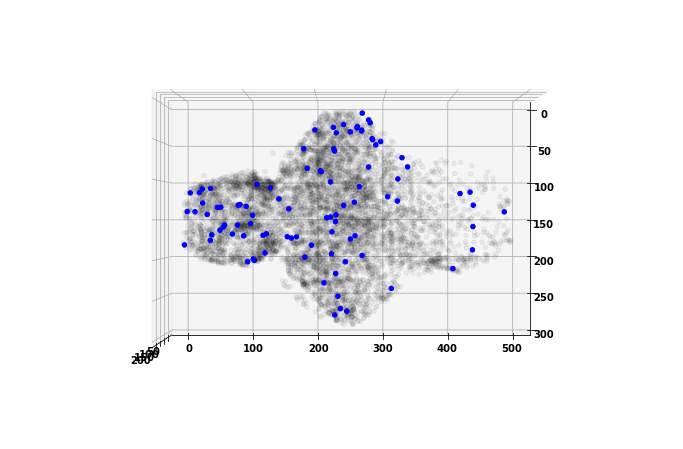

95


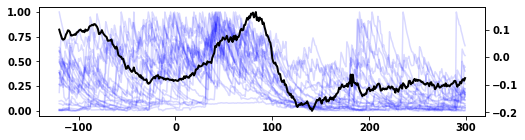

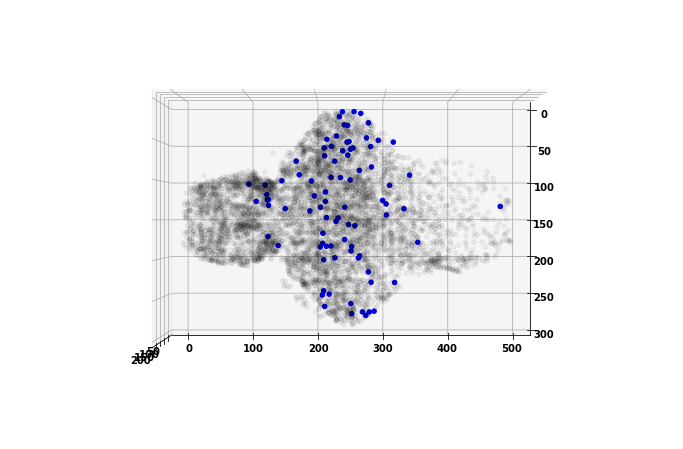

86


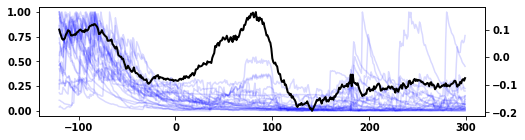

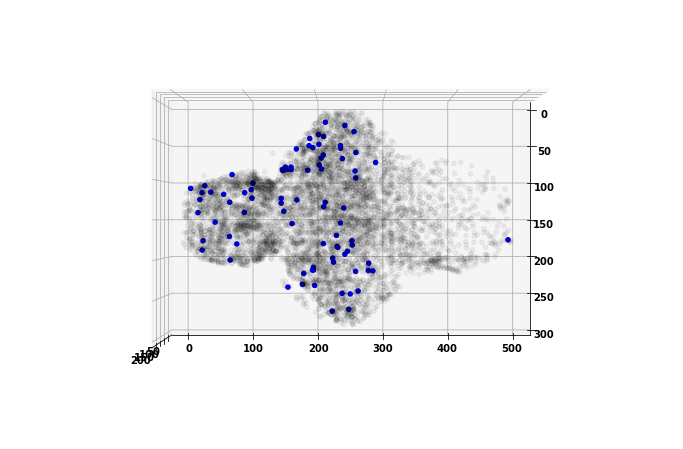

85


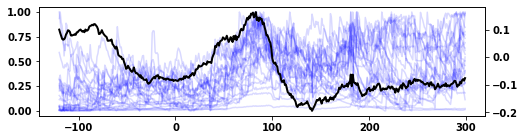

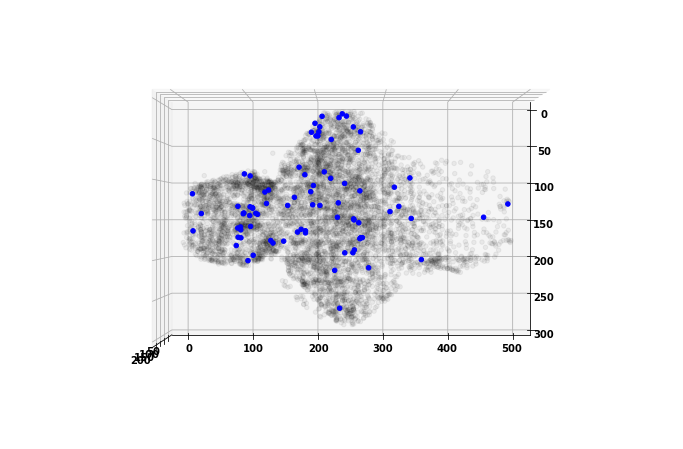

81


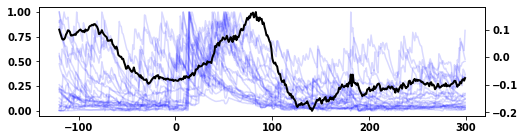

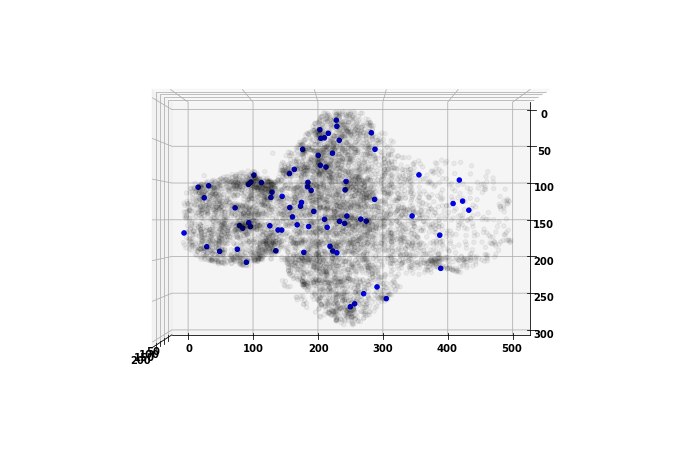

77


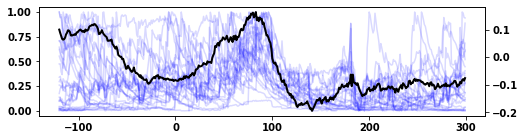

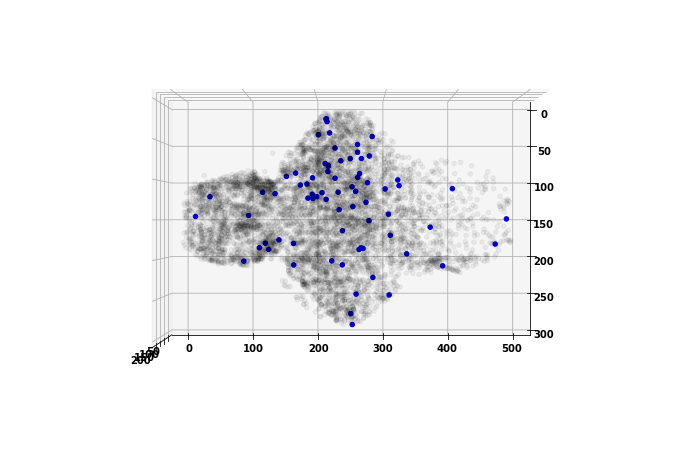

73


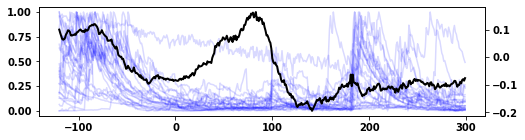

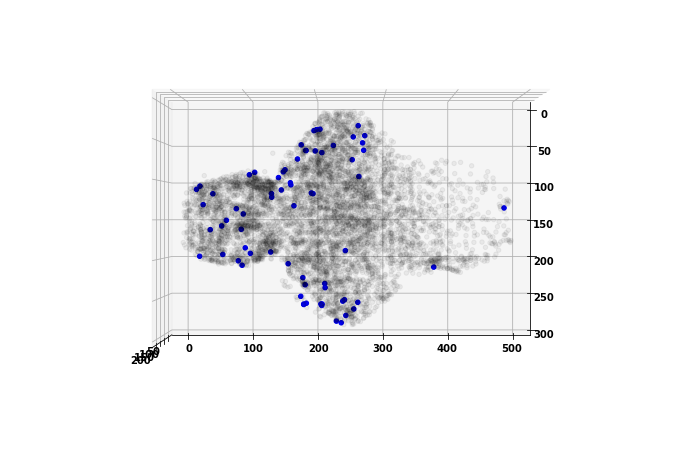

69


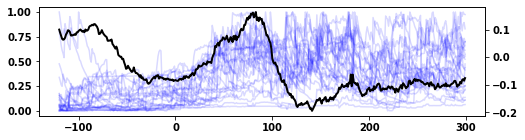

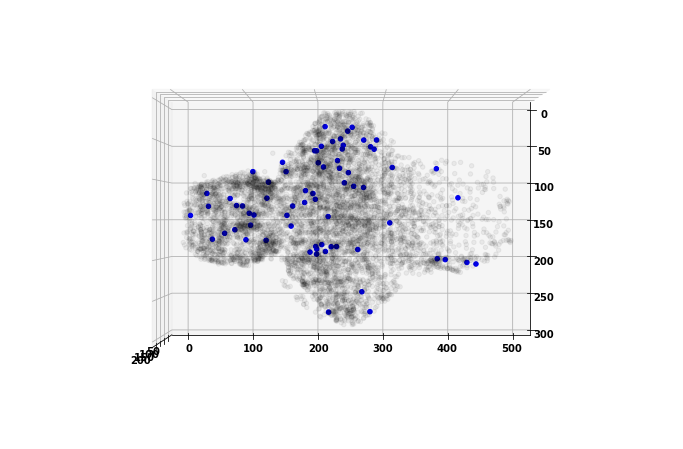

69


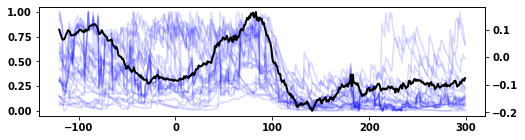

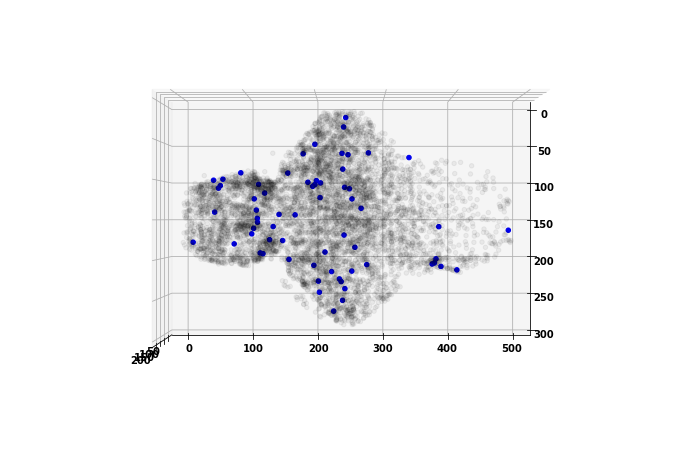

65


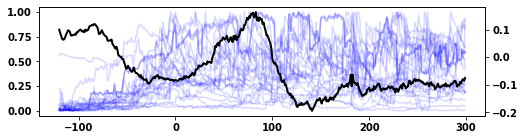

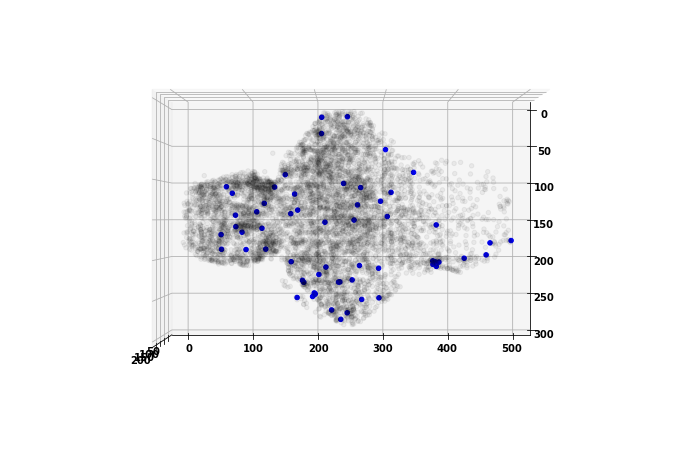

61


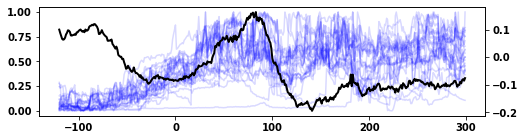

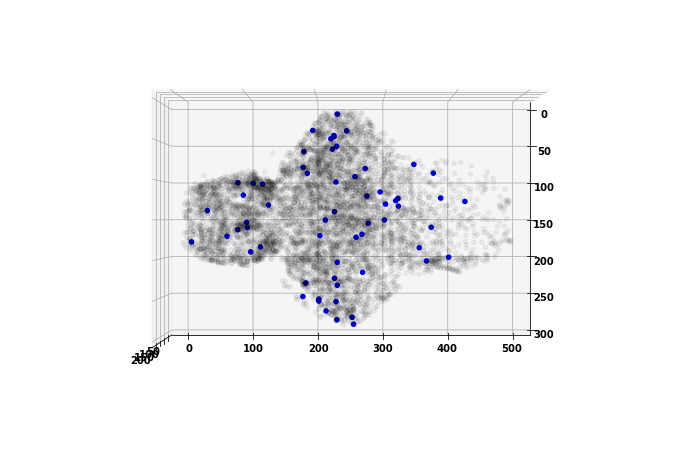

61


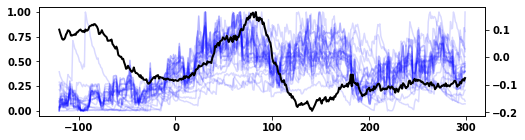

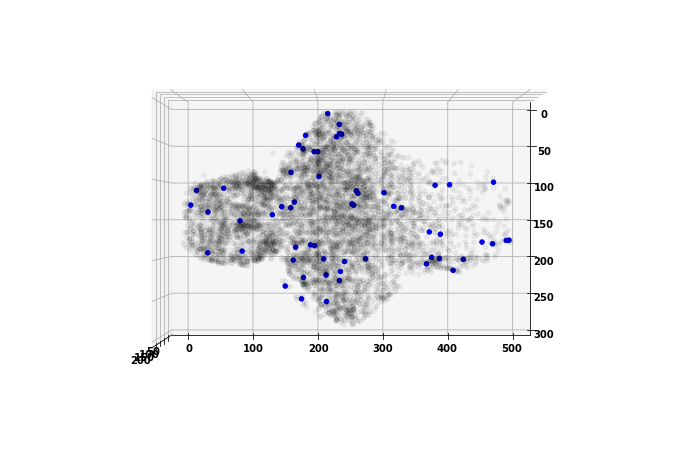

58


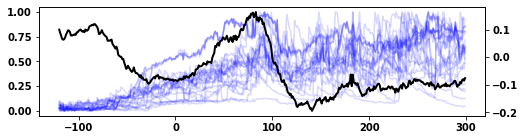

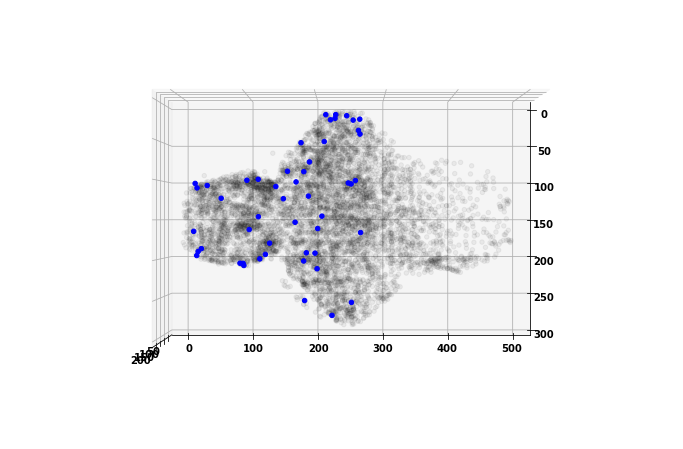

50


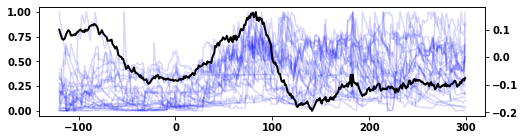

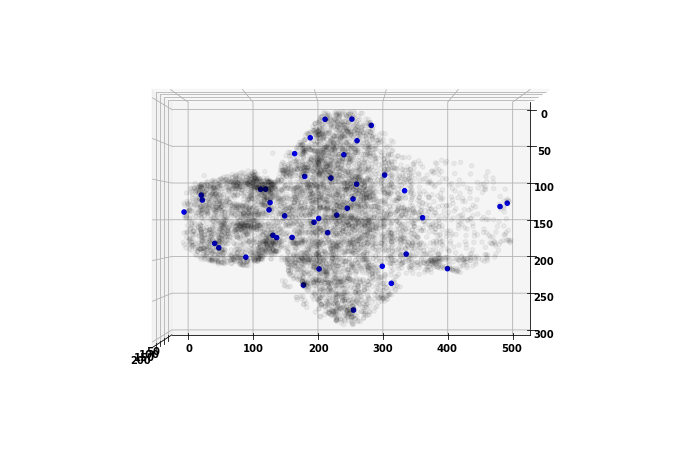

42


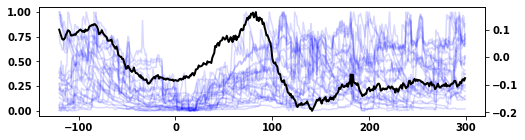

In [303]:
key = 25
X1 = baseline_superhub_outputs

#def plot_superhub_subnetworks(spatial_coords, traces, key, valid_idxs, sorted_idxs, raster, cluster_ids, view, colors=None, plot=True):

#baseline_neurons_per_state = plot_superhub_subnetworks(coords, traces, key, X1[key]['valid idxs'], X1[key]['oslabels'], X1[key]['sorted raster'], X1[key]['tlabels'],
#                                                       [90,0], colors='b', plot=False)


baseline_neurons_per_state, baseline_distances = plot_ensembles(coords, traces, key, X1[key]['valid idxs'],X1[key]['oslabels'], X1[key]['sorted raster'], X1[key]['slabels'], 
                                                           [90,0], colors='b', plot=True)



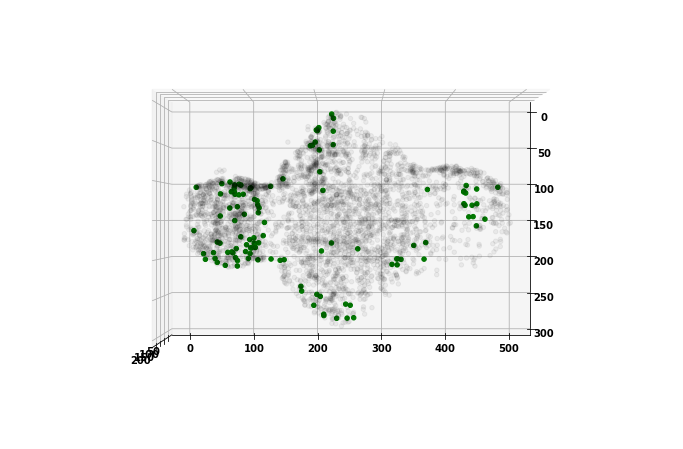

115


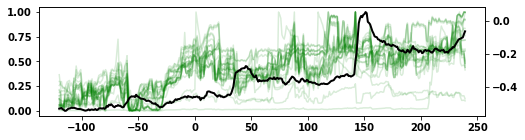

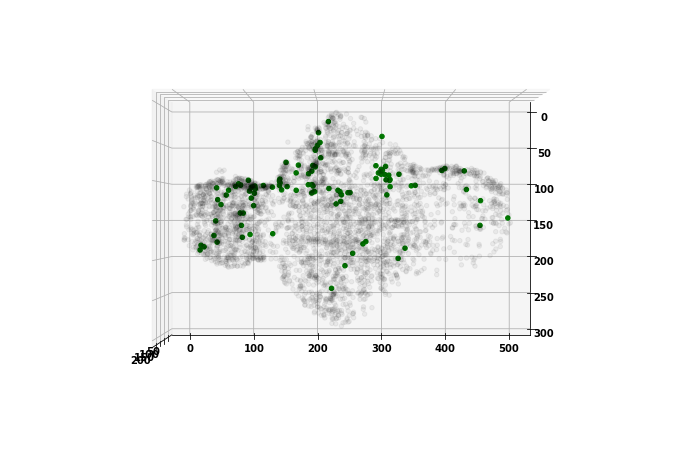

98


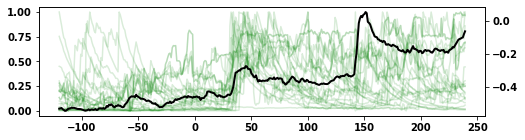

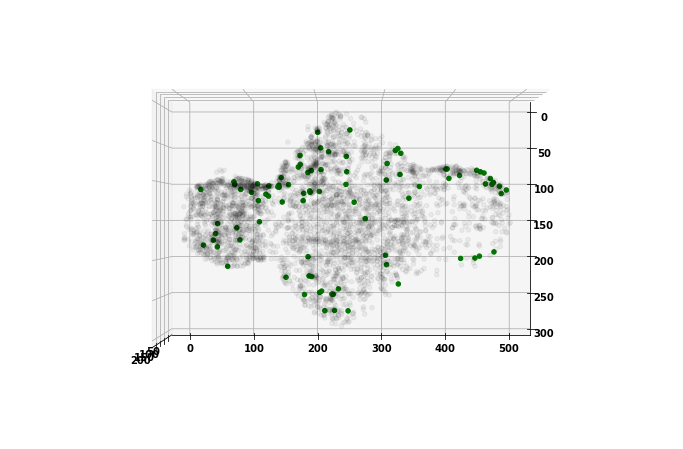

87


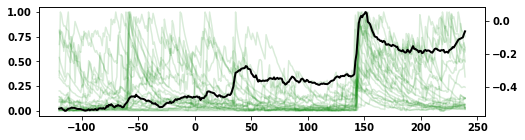

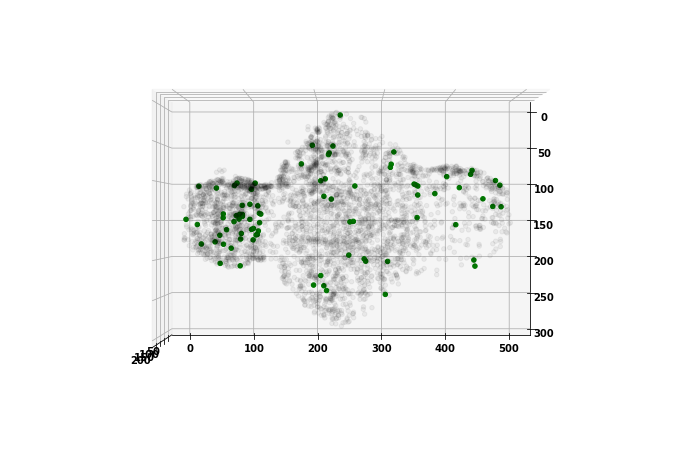

82


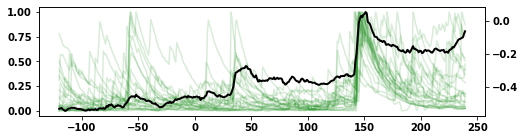

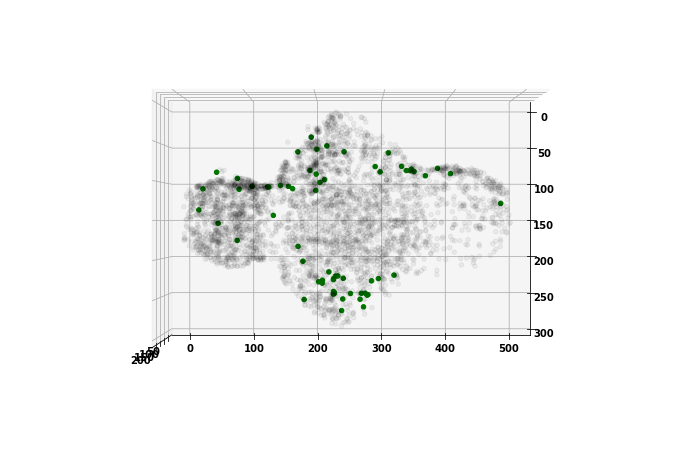

64


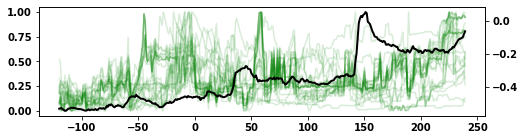

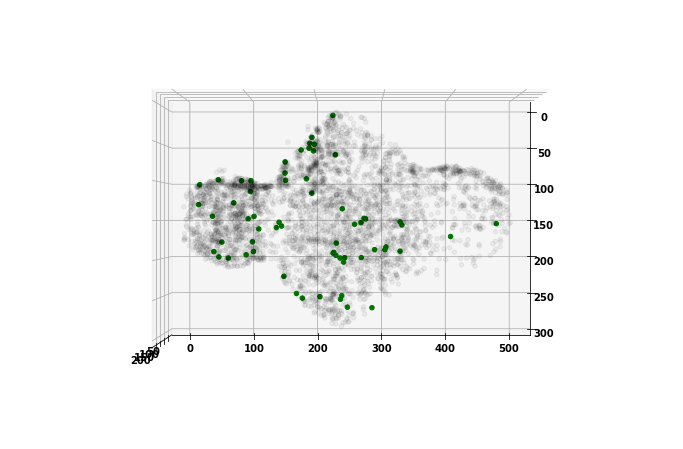

63


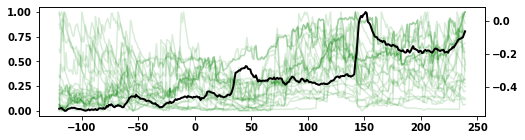

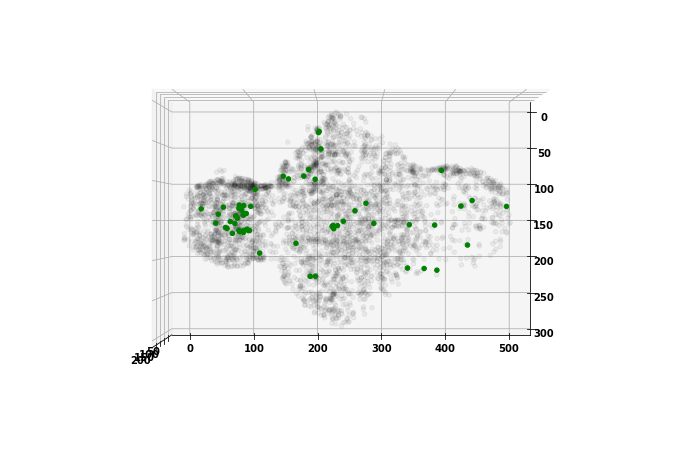

58


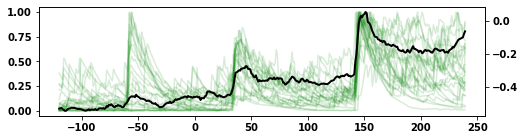

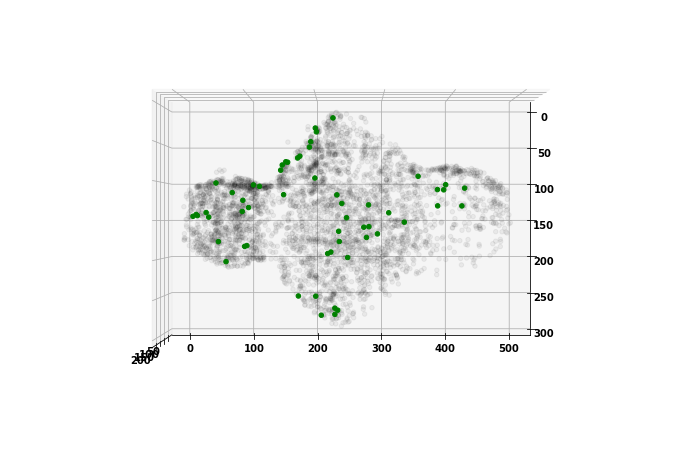

57


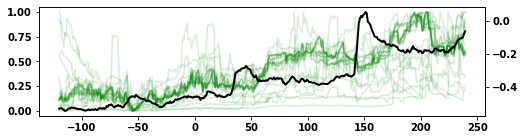

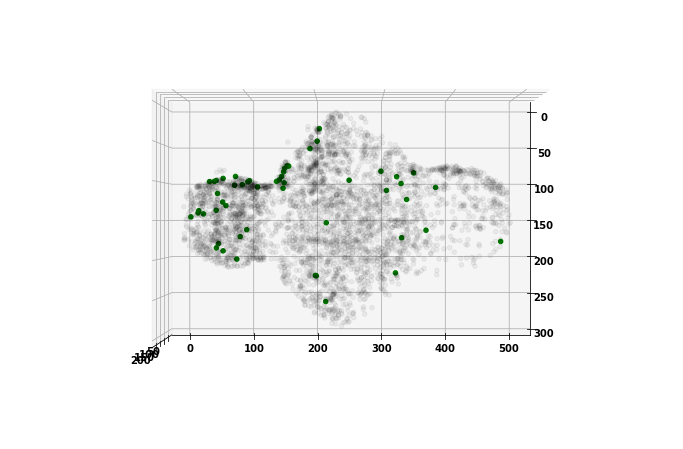

52


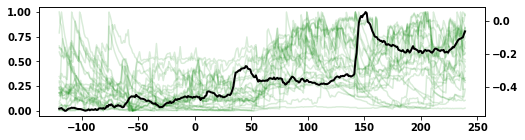

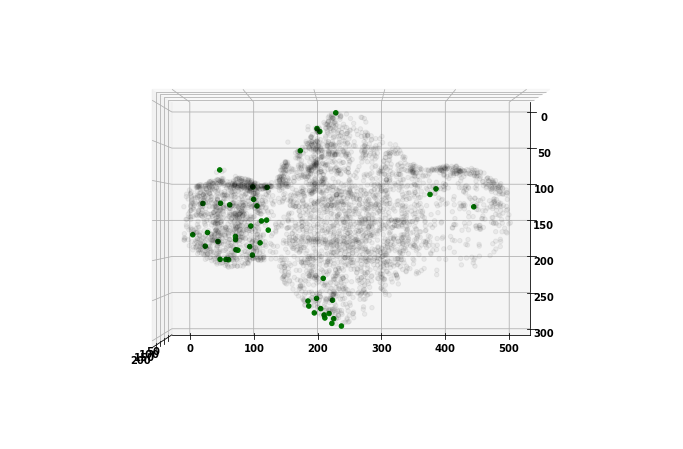

46


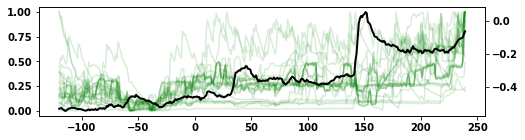

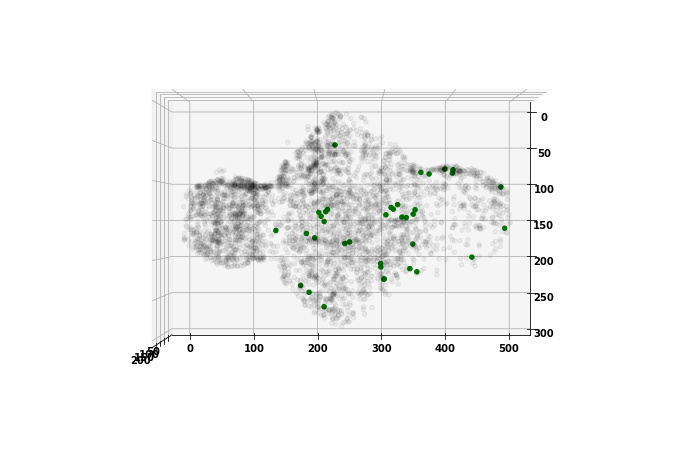

37


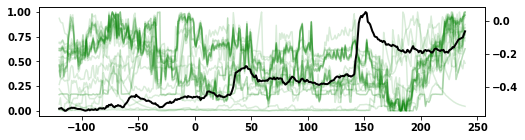

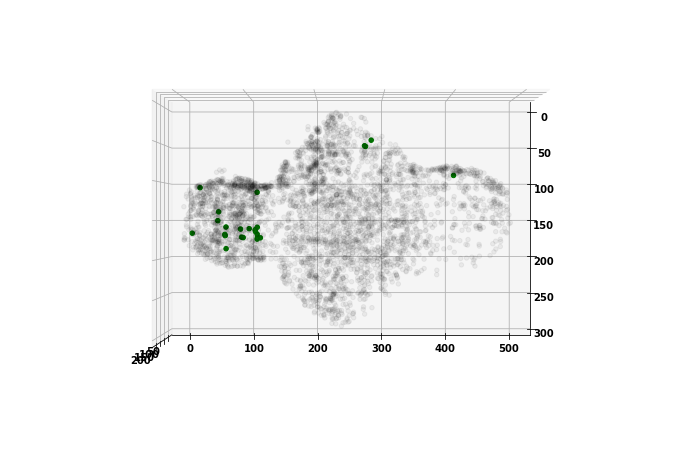

24


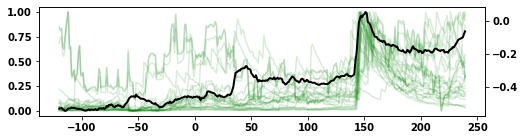

In [430]:
key = max_key
X2 = presz_superhub_outputs
#presz_neurons_per_state = plot_superhub_subnetworks(coords, traces, key, X2[key]['valid idxs'], X2[key]['oslabels'], X2[key]['raster'], X2[key]['tlabels'], 
#                                                    [90,0], colors='r', plot=False)

presz_neurons_per_state, presz_distances = plot_ensembles(coords, traces, key, X2[key]['valid idxs'], X2[key]['oslabels'], X2[key]['sorted raster'], X2[key]['slabels'], 
                                                        [90,0], colors='g', plot=True)


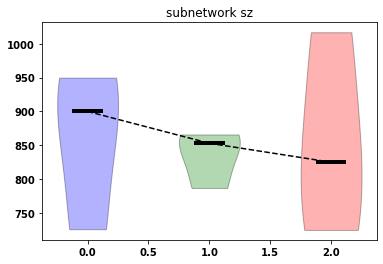

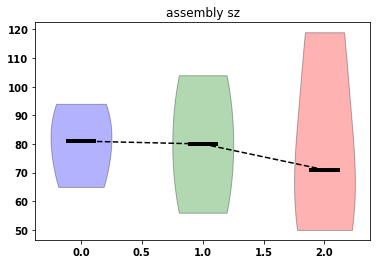

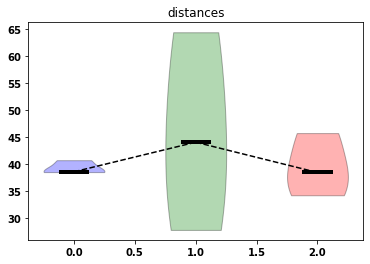

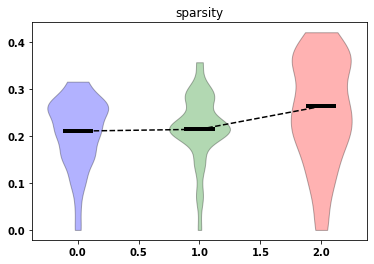

In [386]:
def vplots(X, keys, idx, title):

    data2plot = []
    for key in keys:
        data2plot.append(X[key][idx])

    fig, ax = plt.subplots()
    vplot = ax.violinplot(data2plot, showmedians=True, showextrema=False,
                           positions=range(len(keys)))
    plt.title(title)
    if len(keys) == 3:
        colors = ['b', 'g', 'r']
        for patch, color in zip(vplot['bodies'], colors):
            patch.set_facecolor(color)
            patch.set_edgecolor('k')

        for partname in ['cmedians']:
            vp = vplot[partname]
            vp.set_edgecolor('k')
            vp.set_linewidth(4)
        plt.plot([0,1], [np.median(data2plot[0]),np.median(data2plot[1])], color='k', linestyle='--')
        plt.plot([1,2], [np.median(data2plot[1]),np.median(data2plot[2])], color='k', linestyle='--')        
    
    plt.show()


#return neurons_per_subnetwork, neurons_per_assembly, assembly_distances


vplots(subnetwork_data, keys, 0, 'subnetwork sz')
vplots(subnetwork_data, keys, 1, 'assembly sz')
vplots(subnetwork_data, keys, 2, 'distances')
vplots(subnetwork_data, keys, 3, 'sparsity')


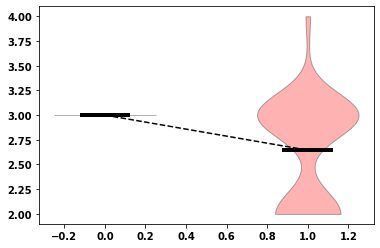

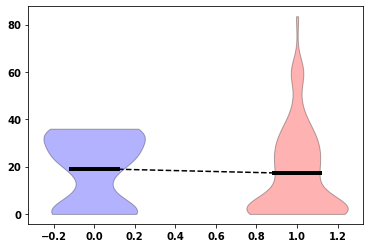

In [56]:
def number_state_transitions(outputs):
    keys = np.sort(list(outputs.keys()))
    ntransitions = []
    for k in keys:
        ntransitions.append(len(set(outputs[k]['tlabels'])))
    return ntransitions

def duration_of_states(outputs):
    keys = np.sort(list(outputs.keys()))
    durations = []
    for k in keys:
        tlabels = outputs[k]['tlabels']
        clabel = None
        dur = 0
        for label in tlabels:
            if clabel is None:
                clabel = label
                continue
            if label == clabel: dur += 1
            else:
                clabel = label
                durations.append(dur)
                dur = 0
    return np.asarray(durations)

# more transitions per minute
baseline_ntransitions = number_state_transitions(baseline_superhub_outputs)
presz_ntransitions    = number_state_transitions(presz_superhub_outputs)

fig, ax = plt.subplots()
vplot = ax.violinplot([baseline_ntransitions, presz_ntransitions], showmeans=True, showextrema=False,
                           positions=[0,1])
ax.plot([0,1], [np.mean(baseline_ntransitions), np.mean(presz_ntransitions)], color='k', linestyle='--')

colors = ['b', 'r']
for patch, color in zip(vplot['bodies'], colors):
    patch.set_facecolor(color)
    patch.set_edgecolor('k')
for partname in ['cmeans']:
    vp = vplot[partname]
    
    vp.set_edgecolor('k')
    vp.set_linewidth(4)

baseline_durations = duration_of_states(baseline_superhub_outputs)
presz_durations    = duration_of_states(presz_superhub_outputs)

fig, ax = plt.subplots()
vplot = ax.violinplot([baseline_durations/2., presz_durations/2.], showmeans=True, showextrema=False,
                           positions=[0,1])
ax.plot([0,1], [np.mean(baseline_durations/2.), np.mean(presz_durations/2.)], color='k', linestyle='--')


colors = ['b', 'r']
for patch, color in zip(vplot['bodies'], colors):
    patch.set_facecolor(color)
    patch.set_edgecolor('k')
for partname in ['cmeans']:
    vp = vplot[partname]
    vp.set_edgecolor('k')
    vp.set_linewidth(4)